In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from pandas.plotting import lag_plot

from pandas.plotting import autocorrelation_plot

import statsmodels.api as sm

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


**- What are the limitations of using this dataset as a way of studying everyday problems of residents?**  
**- What other kinds of data would you use to get a more complete picture? **  
**- What would you change or add to your work, if you had more time? **  
  
1 - There is no population data so you don't have crime rates   
2 - Crime can be different block by block in NYC so forecasting at the precint level won't provide this level of data, which is important for where people decide to live, the sector level will provide more granular data
3 - not all problems are criminal, such as rodent infestations, adding 311 data (NYC all complaints) will add additional perspective on everyday problems. 
4 - There is no information on crimes relative to other cities, so it's possible (although not in fact the case) that even the highest crime precinct would not be considered a high crime precinct in other cities.

# Import the Data

In [3]:
#read data in from pickle file
df = pd.read_pickle('C:/Users/Stacey/Downloads/NY_complaint_data_cleaned.pkl')

In [4]:
df.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,PARKS_NM,HADEVELOPT,Latitude,Longitude,CMPLNT_FR_DATE,CMPLNT_FR_DATE_YEAR,CMPLNT_FR_DATE_MONTH,BORO,CAT_OFNS,BORO_PREC
0,101109527,12/31/2015,23:45:00,NaT,nan,2015-12-31,113,FORGERY,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,NaN,NaN,40.828848,-73.916661,2015-12-31,2015,12,BRONX,FELONY-FORGERY,BRONX-44
1,153401121,12/31/2015,23:36:00,NaT,nan,2015-12-31,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,...,NaN,NaN,40.697338,-73.784557,2015-12-31,2015,12,QUEENS,FELONY-MURDER & NON-NEGL. MANSLAUGHTER,QUEENS-103
2,569369778,12/31/2015,23:30:00,NaT,nan,2015-12-31,117,DANGEROUS DRUGS,503.0,"CONTROLLED SUBSTANCE,INTENT TO",...,NaN,NaN,40.802607,-73.945052,2015-12-31,2015,12,MANHATTAN,FELONY-DANGEROUS DRUGS,MANHATTAN-28
3,968417082,12/31/2015,23:30:00,NaT,nan,2015-12-31,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,NaN,NaN,40.654549,-73.726339,2015-12-31,2015,12,QUEENS,MISDEMEANOR-ASSAULT 3 & RELATED OFFENSES,QUEENS-105
4,641637920,12/31/2015,23:25:00,2015-12-31,23:30:00,2015-12-31,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,NaN,NaN,40.738002,-73.987891,2015-12-31,2015,12,MANHATTAN,MISDEMEANOR-ASSAULT 3 & RELATED OFFENSES,MANHATTAN-13


In [5]:
#read data in from pickle file
precincts_by_boro = pd.read_pickle('C:/Users/Stacey/Downloads/NY_precincts_by_boro.pkl')

In [ ]:
precincts_by_boro.head()

# Create a grouped dataframe to explore timeseries
- count by category, offense type, boro, precinct, year, month

In [6]:
#group complaint data by year, month, borough, precinct, category, 
#description
df_agg = df[['CMPLNT_NUM','CMPLNT_FR_DATE_YEAR','CMPLNT_FR_DATE_MONTH',
             'BORO','PRECINCT','LAW_CAT_CD','OFNS_DESC','CAT_OFNS']
           ].groupby(['CMPLNT_FR_DATE_YEAR','CMPLNT_FR_DATE_MONTH',
                      'BORO','PRECINCT','LAW_CAT_CD',
                      'OFNS_DESC','CAT_OFNS'],as_index=False).agg(['count'])

#reformat headers
df_agg.columns = ['_'.join(tup).rstrip('_') for tup in df_agg.columns.values]
df_agg.reset_index(col_level=1,inplace = True)

In [7]:
df_agg.head()

,CMPLNT_FR_DATE_YEAR,CMPLNT_FR_DATE_MONTH,BORO,PRECINCT,LAW_CAT_CD,OFNS_DESC,CAT_OFNS,CMPLNT_NUM_count
0,2006,1,BRONX,40,FELONY,ARSON,FELONY-ARSON,4
1,2006,1,BRONX,40,FELONY,BURGLARY,FELONY-BURGLARY,28
2,2006,1,BRONX,40,FELONY,CRIMINAL MISCHIEF & RELATED OF,FELONY-CRIMINAL MISCHIEF & RELATED OF,16
3,2006,1,BRONX,40,FELONY,DANGEROUS DRUGS,FELONY-DANGEROUS DRUGS,30
4,2006,1,BRONX,40,FELONY,DANGEROUS WEAPONS,FELONY-DANGEROUS WEAPONS,16


In [8]:
df_agg.sort_values(['BORO','PRECINCT','CAT_OFNS',
                     'CMPLNT_FR_DATE_YEAR','CMPLNT_FR_DATE_MONTH'],
                  inplace = True)

In [9]:
list(df_agg)

['CMPLNT_FR_DATE_YEAR',
 'CMPLNT_FR_DATE_MONTH',
 'BORO',
 'PRECINCT',
 'LAW_CAT_CD',
 'OFNS_DESC',
 'CAT_OFNS',
 'CMPLNT_NUM_count']

In [10]:
#rename columns
df_agg.rename(columns={'CMPLNT_FR_DATE_YEAR':'YEAR',
 'CMPLNT_FR_DATE_MONTH':'MONTH',
 'LAW_CAT_CD':'CRIME_CAT',
 'OFNS_DESC':'OFFENSE',
 'CMPLNT_NUM_count':'COUNT'}, inplace = True)

In [11]:
list(df_agg)

['YEAR',
 'MONTH',
 'BORO',
 'PRECINCT',
 'CRIME_CAT',
 'OFFENSE',
 'CAT_OFNS',
 'COUNT']

In [12]:
df_agg.head()

,YEAR,MONTH,BORO,PRECINCT,CRIME_CAT,OFFENSE,CAT_OFNS,COUNT
0,2006,1,BRONX,40,FELONY,ARSON,FELONY-ARSON,4
2459,2006,2,BRONX,40,FELONY,ARSON,FELONY-ARSON,7
4823,2006,3,BRONX,40,FELONY,ARSON,FELONY-ARSON,3
7295,2006,4,BRONX,40,FELONY,ARSON,FELONY-ARSON,3
9718,2006,5,BRONX,40,FELONY,ARSON,FELONY-ARSON,2


In [13]:
#create a date
df_agg['DAY'] = 1 


In [14]:
df_agg['DATE'] = pd.to_datetime(df_agg[['YEAR','MONTH','DAY']])

In [15]:
df_agg.head()

,YEAR,MONTH,BORO,PRECINCT,CRIME_CAT,OFFENSE,CAT_OFNS,COUNT,DAY,DATE
0,2006,1,BRONX,40,FELONY,ARSON,FELONY-ARSON,4,1,2006-01-01
2459,2006,2,BRONX,40,FELONY,ARSON,FELONY-ARSON,7,1,2006-02-01
4823,2006,3,BRONX,40,FELONY,ARSON,FELONY-ARSON,3,1,2006-03-01
7295,2006,4,BRONX,40,FELONY,ARSON,FELONY-ARSON,3,1,2006-04-01
9718,2006,5,BRONX,40,FELONY,ARSON,FELONY-ARSON,2,1,2006-05-01


In [16]:
len(df_agg.CAT_OFNS.unique())

81

** There are:  
77 precincts (in 5 boroughs), and several times as many sectors   
81 offense types **

In [65]:
offenses = ['FELONY-GRAND LARCENY','MISDEMEANOR-PETIT LARCENY','VIOLATION-HARRASSMENT 2']
precincts = [75,69,102,73]
combinations = [(x,y) for x in precincts for y in offenses]
combinations

[(75, 'FELONY-GRAND LARCENY'),
 (75, 'MISDEMEANOR-PETIT LARCENY'),
 (75, 'VIOLATION-HARRASSMENT 2'),
 (69, 'FELONY-GRAND LARCENY'),
 (69, 'MISDEMEANOR-PETIT LARCENY'),
 (69, 'VIOLATION-HARRASSMENT 2'),
 (102, 'FELONY-GRAND LARCENY'),
 (102, 'MISDEMEANOR-PETIT LARCENY'),
 (102, 'VIOLATION-HARRASSMENT 2'),
 (73, 'FELONY-GRAND LARCENY'),
 (73, 'MISDEMEANOR-PETIT LARCENY'),
 (73, 'VIOLATION-HARRASSMENT 2')]

In [69]:
df_agg_75 = df_agg[(df_agg.PRECINCT.isin(precincts)) &
                  (df_agg.CAT_OFNS.isin(offenses))]

In [70]:
df_agg_75.head()

,YEAR,MONTH,BORO,PRECINCT,CRIME_CAT,OFFENSE,CAT_OFNS,COUNT,DAY,DATE
651,2006,1,BROOKLYN,69,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,34,1,2006-01-01
3098,2006,2,BROOKLYN,69,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,35,1,2006-02-01
5476,2006,3,BROOKLYN,69,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,37,1,2006-03-01
7932,2006,4,BROOKLYN,69,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,35,1,2006-04-01
10368,2006,5,BROOKLYN,69,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,40,1,2006-05-01


** Time Series Plot for the highest crime precinct and surrounding precincts by top offense type in each category **  
Brooklyn Precinct 75  
Adjacent Precincts by varying levels of crime: 73,69,102

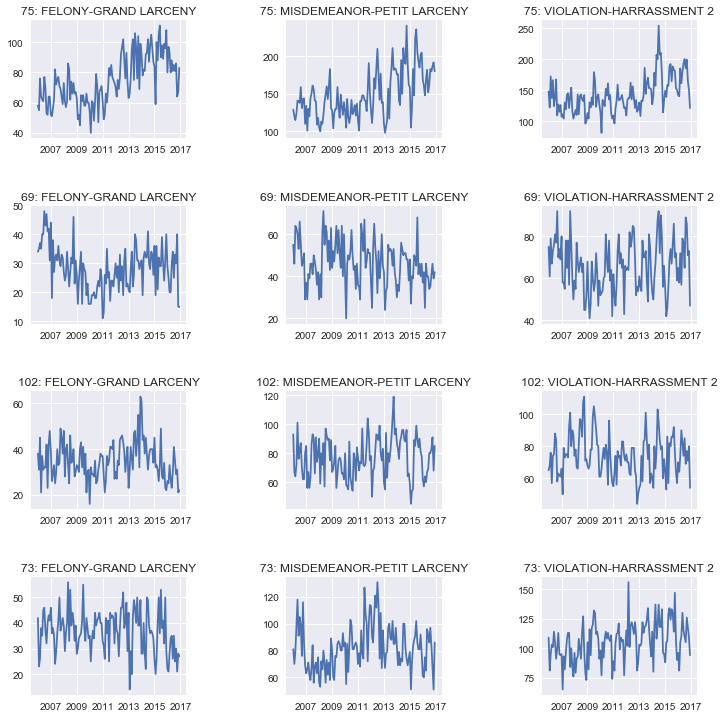

In [72]:
f, axs = plt.subplots(4, 3, figsize=(10, 10))
plt.tight_layout(h_pad=4.0,w_pad=6.0)

for i, ax in enumerate(axs.flat):
    precinct,offense = combinations[i]
    ts_df = df_agg_75[(df_agg_75.PRECINCT == precinct) &
                       (df_agg_75.CAT_OFNS.str.contains(offense))]
    ax.plot(ts_df.DATE, ts_df.COUNT)
    ax.set_title(str(precinct) + ': ' + offense)

This set of adjacent precincts do not appear to show similar time series

** Box plot by YEAR by Boro and Crime Category **   
evaluate multi-year trends and distribution by year

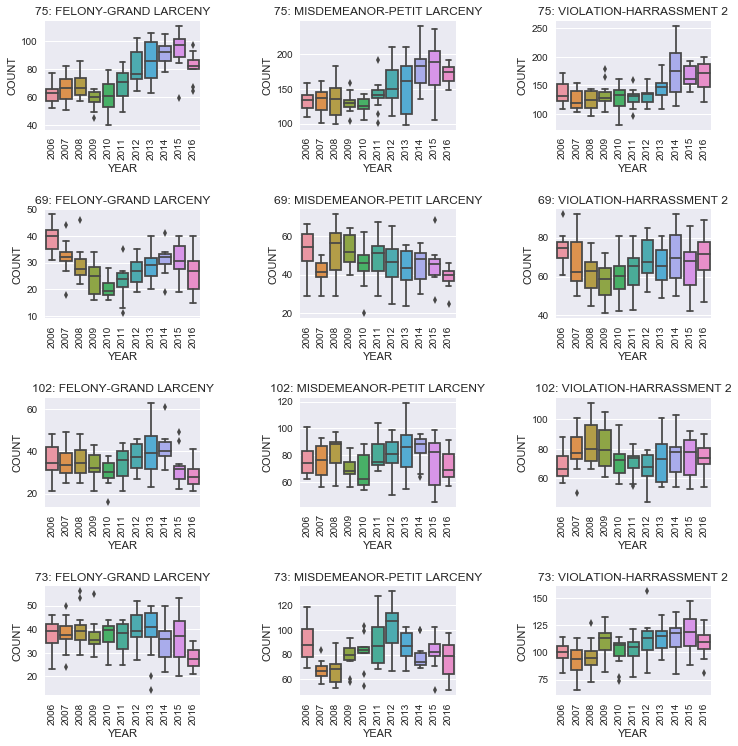

In [108]:
#show boxplot by year
f, axs = plt.subplots(4, 3, figsize=(10, 10))
plt.tight_layout(h_pad=5.0,w_pad=6.0)

for i, ax in enumerate(axs.flat):
    precinct,offense = combinations[i]
    ts_df = df_agg_75[(df_agg_75.PRECINCT == precinct) &
                       (df_agg_75.CAT_OFNS.str.contains(offense))]
    g = sns.boxplot(x ='YEAR', y='COUNT' , data = ts_df,ax=ax)
    ax.set_title(str(precinct) + ': ' + offense)
    g.set_xticklabels(ax.get_xticklabels(),rotation=90)

This confirms what the time series showed above

** Lag plot (lag = 1) by Boro and Crime Category **   
Time sereis modeling assumes a relationship between an observation and the previous observation  
View correlation between observations and previous observation.  
  
The data shows a strong positive correlation for precinct 75, less so for adjacent districts

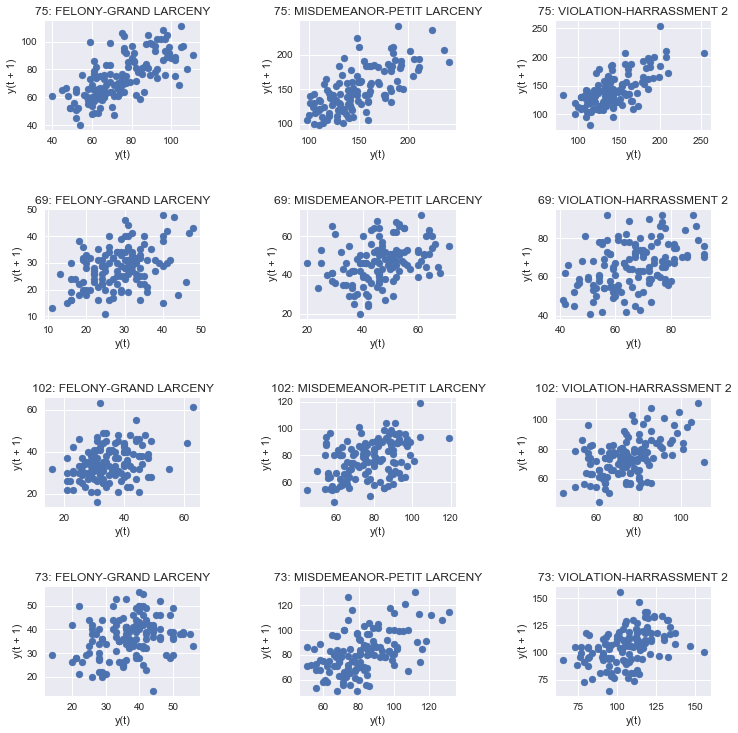

In [102]:
#Time Series Lag Scatter Plots by year
f, axs = plt.subplots(4, 3, figsize=(10, 10))
plt.tight_layout(h_pad=5.0,w_pad=6.0)

for i, ax in enumerate(axs.flat):
    precinct,offense = combinations[i]
    ts_df = df_agg_75[(df_agg_75.PRECINCT == precinct) &
                       (df_agg_75.CAT_OFNS.str.contains(offense))]
    g = lag_plot(ts_df.COUNT,ax=ax)
    ax.set_title(str(precinct) + ': ' + offense)

** Autocorrelation plots by Boro and Crime Category **   
lag is shown along the x-axis and correlation along the y-axis  
dotted lines indicate statistically signficant above those lines. sign indicates negative or positive correlation.
Many of the plots show sine waves that are a strong sign of seasonality in the dataset: since the plot captures the relationship of an observation with past observations in the same and opposite seasons or times of year. 

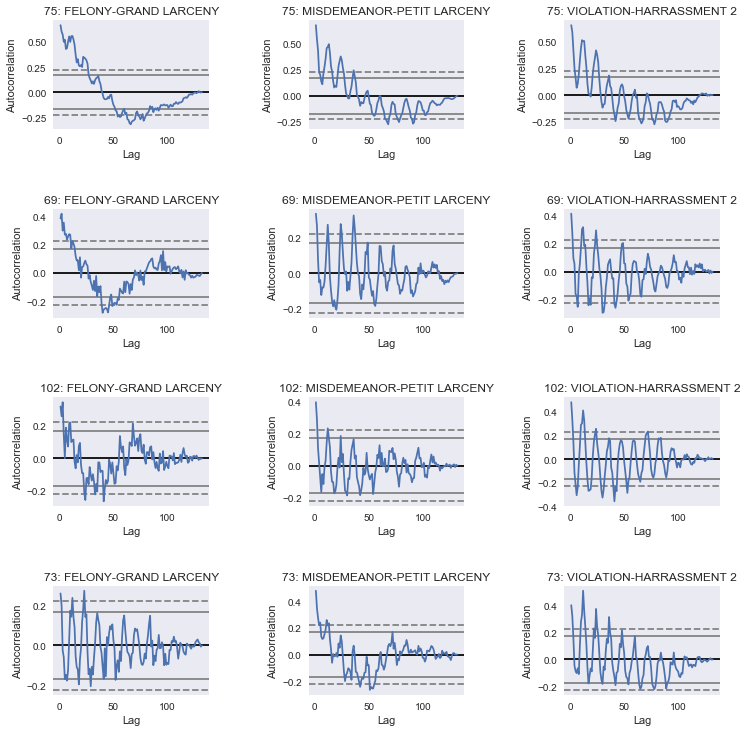

In [109]:
#Time Series Lag Scatter Plots by year
f, axs = plt.subplots(4, 3, figsize=(10, 10))
plt.tight_layout(h_pad=5.0,w_pad=6.0)

for i, ax in enumerate(axs.flat):
    precinct,offense = combinations[i]
    ts_df = df_agg_75[(df_agg_75.PRECINCT == precinct) &
                       (df_agg_75.CAT_OFNS.str.contains(offense))]
    g = autocorrelation_plot(ts_df.COUNT,ax=ax)
    ax.set_title(str(precinct) + ': ' + offense)

** Difference by 1 and view time series and resulting auto correlation**  
Differencing is a way to create a stationary time series from a non-stationary time series, LSTM requires a stationary time series. 

In [93]:
#difference by 1 and view time series
df_agg_75['COUNT_shifted'] = df_agg_75.groupby(['PRECINCT','CAT_OFNS'])['COUNT'].shift(1)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [94]:
df_agg_75['diff_1'] = df_agg_75.COUNT - df_agg_75.COUNT_shifted

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [95]:
df_agg_75.head()

,YEAR,MONTH,BORO,PRECINCT,CRIME_CAT,OFFENSE,CAT_OFNS,COUNT,DAY,DATE,COUNT_shifted,diff_1
651,2006,1,BROOKLYN,69,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,34,1,2006-01-01,NaN,NaN
3098,2006,2,BROOKLYN,69,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,35,1,2006-02-01,34.0,1.0
5476,2006,3,BROOKLYN,69,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,37,1,2006-03-01,35.0,2.0
7932,2006,4,BROOKLYN,69,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,35,1,2006-04-01,37.0,-2.0
10368,2006,5,BROOKLYN,69,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,40,1,2006-05-01,35.0,5.0


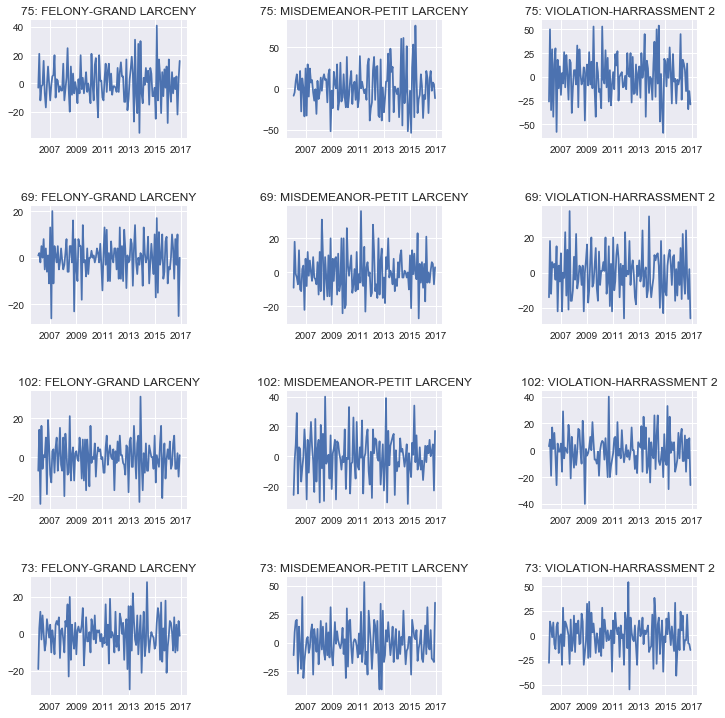

In [96]:
f, axs = plt.subplots(4, 3, figsize=(10, 10))
plt.tight_layout(h_pad=4.0,w_pad=6.0)

for i, ax in enumerate(axs.flat):
    precinct,offense = combinations[i]
    ts_df = df_agg_75[(df_agg_75.PRECINCT == precinct) &
                       (df_agg_75.CAT_OFNS.str.contains(offense))].iloc[1:,:]
    ax.plot(ts_df.DATE, ts_df.diff_1)
    ax.set_title(str(precinct) + ': ' + offense)

** View autocorrelation Plots after differencing **

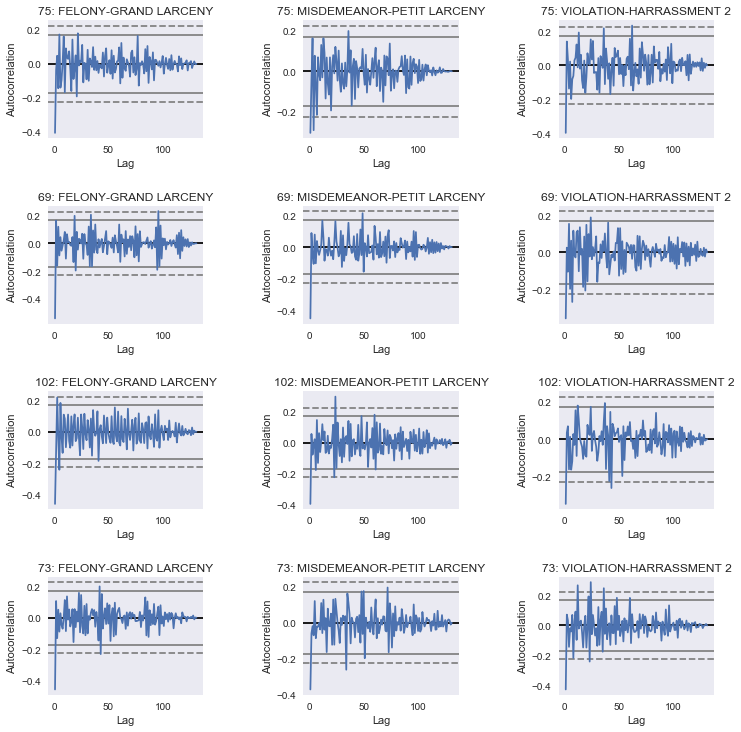

In [97]:
f, axs = plt.subplots(4, 3, figsize=(10, 10))
plt.tight_layout(h_pad=4.0,w_pad=6.0)

for i, ax in enumerate(axs.flat):
    precinct,offense = combinations[i]
    ts_df = df_agg_75[(df_agg_75.PRECINCT == precinct) &
                       (df_agg_75.CAT_OFNS.str.contains(offense))].iloc[1:,:]
    g = autocorrelation_plot(ts_df.diff_1,ax=ax)
    ax.set_title(str(precinct) + ': ' + offense)

Autocorrelation is reduced but not eliminated, time series are closer to stationary.